# Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import KBinsDiscretizer
from numpy import mean
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# Importing the Data for ML Project

In [2]:
url = 'https://raw.githubusercontent.com/BhargavArunkumar/Hotel_Demand_Prediction/main/DataSet/hotel_bookings.csv'

In [3]:
df = pd.read_csv(url, header=0)

In [4]:
df.shape

(119390, 33)

In [5]:
df.head()

,hotel,is_canceled,lead_time,arrival_month_year,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,July 2015,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01-07-2015
1,Resort Hotel,0,737,July 2015,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,01-07-2015
2,Resort Hotel,0,7,July 2015,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,02-07-2015
3,Resort Hotel,0,13,July 2015,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,02-07-2015
4,Resort Hotel,0,14,July 2015,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,03-07-2015


In [6]:
df.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_month_year                 object
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                      

# Setting Display options to ensure feature name visibility

In [7]:
pd.set_option('display.max_columns',None)

# Warning Suppression 

In [8]:
import warnings
warnings.filterwarnings('ignore')

# Drop ID Feature from the dataset

In [9]:
# No ID is mentioned so we don't perform the drop step

# Defining Target and Independent Features

In [10]:
Y=df[['is_canceled']]
X=df.drop(['is_canceled'],axis=1)

# Get the Response Rate

In [11]:
Y.mean()

is_canceled    0.370416
dtype: float64

# Split features into Numerical and Categorical

In [12]:
num=X.select_dtypes(include="number")
char=X.select_dtypes(include="object")

In [13]:
def unique_levels(x):
    x=x.value_counts().count()
    return(x)
df_value_counts=pd.DataFrame(num.apply(lambda x : unique_levels(x)))

In [14]:
df_value_counts.columns=['feature_levels']
df_value_counts.head()

,feature_levels
lead_time,479
arrival_date_year,3
arrival_date_week_number,53
arrival_date_day_of_month,31
stays_in_weekend_nights,17


In [15]:
slice1=df_value_counts.loc[df_value_counts['feature_levels']<=20]
cat_list=slice1.index
cat=num.loc[:,cat_list]
cat.dtypes

arrival_date_year                int64
stays_in_weekend_nights          int64
adults                           int64
children                       float64
babies                           int64
is_repeated_guest                int64
previous_cancellations           int64
required_car_parking_spaces      int64
total_of_special_requests        int64
dtype: object

In [16]:
slice2=df_value_counts.loc[df_value_counts['feature_levels']>20]
num_list=slice2.index
num=num.loc[:,num_list]

In [17]:
num.dtypes

lead_time                           int64
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_week_nights                int64
previous_bookings_not_canceled      int64
booking_changes                     int64
agent                             float64
company                           float64
days_in_waiting_list                int64
adr                               float64
dtype: object

In [18]:
num.shape

(119390, 10)

In [19]:
char=pd.concat([char,cat],axis=1,join="inner")

In [20]:
char.head()

,hotel,arrival_month_year,arrival_date_month,meal,country,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,reservation_status,reservation_status_date,arrival_date_year,stays_in_weekend_nights,adults,children,babies,is_repeated_guest,previous_cancellations,required_car_parking_spaces,total_of_special_requests
0,Resort Hotel,July 2015,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Check-Out,01-07-2015,2015,0,2,0.0,0,0,0,0,0
1,Resort Hotel,July 2015,July,BB,PRT,Direct,Direct,C,C,No Deposit,Transient,Check-Out,01-07-2015,2015,0,2,0.0,0,0,0,0,0
2,Resort Hotel,July 2015,July,BB,GBR,Direct,Direct,A,C,No Deposit,Transient,Check-Out,02-07-2015,2015,0,1,0.0,0,0,0,0,0
3,Resort Hotel,July 2015,July,BB,GBR,Corporate,Corporate,A,A,No Deposit,Transient,Check-Out,02-07-2015,2015,0,1,0.0,0,0,0,0,0
4,Resort Hotel,July 2015,July,BB,GBR,Online TA,TA/TO,A,A,No Deposit,Transient,Check-Out,03-07-2015,2015,0,2,0.0,0,0,0,0,1


# Outlier Analysis of Numerical Features

In [21]:
num.describe(percentiles=[0.01,0.05,0.10,0.25,0.50,0.75,0.85,0.88,0.9,0.99])

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_week_nights,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000
mean,104.011416,27.165173,15.798241,2.500302,0.137097,0.221124,86.693382,189.266735,2.321149,101.831122
std,106.863097,13.605138,8.780829,1.908286,1.497437,0.652306,110.774548,131.655015,17.594721,50.535790
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,-6.380000
1%,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,16.000000,0.000000,0.000000
5%,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000,1.000000,40.000000,0.000000,38.400000
10%,3.000000,8.000000,4.000000,1.000000,0.000000,0.000000,6.000000,40.000000,0.000000,50.000000
25%,18.000000,16.000000,8.000000,1.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000
50%,69.000000,28.000000,16.000000,2.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000
75%,160.000000,38.000000,23.000000,3.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000


# Capping and Flooring of outliers

In [22]:
def outlier_cap(x):
    x=x.clip(lower=x.quantile(0.01))
    x=x.clip(upper=x.quantile(0.99))
    return(x)

In [23]:
num=num.apply(lambda x : outlier_cap(x))

In [24]:
num.describe(percentiles=[0.01,0.05,0.10,0.25,0.50,0.75,0.85,0.9,0.99])

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_week_nights,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,adr
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000
mean,103.409180,27.173943,15.798241,2.479211,0.060273,0.209574,86.008598,189.206373,1.606902,101.461251
std,104.600923,13.588582,8.780829,1.761267,0.376351,0.555245,108.591334,131.297172,9.760268,46.905036
min,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,16.000000,0.000000,0.000000
1%,0.000000,2.000000,1.000000,0.000000,0.000000,0.000000,1.000000,16.000000,0.000000,0.000000
5%,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000,1.000000,40.000000,0.000000,38.400000
10%,3.000000,8.000000,4.000000,1.000000,0.000000,0.000000,6.000000,40.000000,0.000000,50.000000
25%,18.000000,16.000000,8.000000,1.000000,0.000000,0.000000,9.000000,62.000000,0.000000,69.290000
50%,69.000000,28.000000,16.000000,2.000000,0.000000,0.000000,14.000000,179.000000,0.000000,94.575000
75%,160.000000,38.000000,23.000000,3.000000,0.000000,0.000000,229.000000,270.000000,0.000000,126.000000


# Missing Value Analysis

In [25]:
num.isnull().mean()

lead_time                         0.000000
arrival_date_week_number          0.000000
arrival_date_day_of_month         0.000000
stays_in_week_nights              0.000000
previous_bookings_not_canceled    0.000000
booking_changes                   0.000000
agent                             0.136862
company                           0.943069
days_in_waiting_list              0.000000
adr                               0.000000
dtype: float64

In [26]:
char.isnull().mean()

hotel                          0.000000
arrival_month_year             0.000000
arrival_date_month             0.000000
meal                           0.000000
country                        0.004087
market_segment                 0.000000
distribution_channel           0.000000
reserved_room_type             0.000000
assigned_room_type             0.000000
deposit_type                   0.000000
customer_type                  0.000000
reservation_status             0.000000
reservation_status_date        0.000000
arrival_date_year              0.000000
stays_in_weekend_nights        0.000000
adults                         0.000000
children                       0.000034
babies                         0.000000
is_repeated_guest              0.000000
previous_cancellations         0.000000
required_car_parking_spaces    0.000000
total_of_special_requests      0.000000
dtype: float64

# Dropping variables that have >25% missing values

In [27]:
num = num.loc[:, num.isnull().mean() <= .25]

In [28]:
num.isnull().mean()

lead_time                         0.000000
arrival_date_week_number          0.000000
arrival_date_day_of_month         0.000000
stays_in_week_nights              0.000000
previous_bookings_not_canceled    0.000000
booking_changes                   0.000000
agent                             0.136862
days_in_waiting_list              0.000000
adr                               0.000000
dtype: float64

# Imputation of Missing Values

In [29]:
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
num_1=pd.DataFrame(imputer.fit_transform(num),index=num.index,columns=num.columns)

In [30]:
num_1.isnull().mean()

lead_time                         0.0
arrival_date_week_number          0.0
arrival_date_day_of_month         0.0
stays_in_week_nights              0.0
previous_bookings_not_canceled    0.0
booking_changes                   0.0
agent                             0.0
days_in_waiting_list              0.0
adr                               0.0
dtype: float64

In [31]:
imputer=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
char_1=pd.DataFrame(imputer.fit_transform(char),index=char.index,columns=char.columns)

In [32]:
char_1.isnull().mean()

hotel                          0.0
arrival_month_year             0.0
arrival_date_month             0.0
meal                           0.0
country                        0.0
market_segment                 0.0
distribution_channel           0.0
reserved_room_type             0.0
assigned_room_type             0.0
deposit_type                   0.0
customer_type                  0.0
reservation_status             0.0
reservation_status_date        0.0
arrival_date_year              0.0
stays_in_weekend_nights        0.0
adults                         0.0
children                       0.0
babies                         0.0
is_repeated_guest              0.0
previous_cancellations         0.0
required_car_parking_spaces    0.0
total_of_special_requests      0.0
dtype: float64

# Feature Selection - Numerical Features 

# Part 1 : Remove Features with 0 Variance

In [33]:
varselector= VarianceThreshold(threshold=0)
varselector.fit_transform(num_1)
# Get columns to keep and create new dataframe with those only
cols = varselector.get_support(indices=True)
num_2 = num_1.iloc[:,cols]

In [34]:
num_2.iloc[0]

lead_time                         342.000000
arrival_date_week_number           27.000000
arrival_date_day_of_month           1.000000
stays_in_week_nights                0.000000
previous_bookings_not_canceled      0.000000
booking_changes                     3.000000
agent                              86.008598
days_in_waiting_list                0.000000
adr                                 0.000000
Name: 0, dtype: float64

# Part 1 - Bi Variate Analysis (Feature Discretization)

In [35]:
discrete=KBinsDiscretizer(n_bins=10,encode='ordinal', strategy='quantile')
num_binned=pd.DataFrame(discrete.fit_transform(num_2),index=num_2.index, columns=num_2.columns).add_suffix('_Rank')
num_binned.tail()

,lead_time_Rank,arrival_date_week_number_Rank,arrival_date_day_of_month_Rank,stays_in_week_nights_Rank,previous_bookings_not_canceled_Rank,booking_changes_Rank,agent_Rank,days_in_waiting_list_Rank,adr_Rank
119385,2.0,6.0,9.0,5.0,0.0,0.0,5.0,0.0,5.0
119386,6.0,6.0,9.0,5.0,0.0,0.0,2.0,0.0,9.0
119387,3.0,6.0,9.0,5.0,0.0,0.0,2.0,0.0,8.0
119388,6.0,6.0,9.0,5.0,0.0,0.0,4.0,0.0,5.0
119389,8.0,6.0,9.0,5.0,0.0,0.0,2.0,0.0,8.0


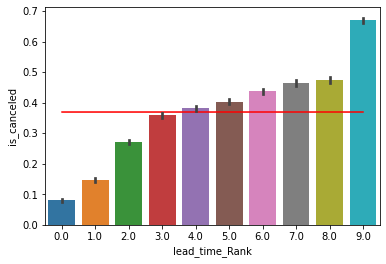

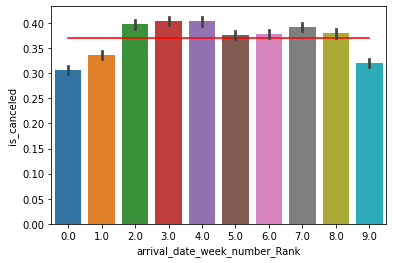

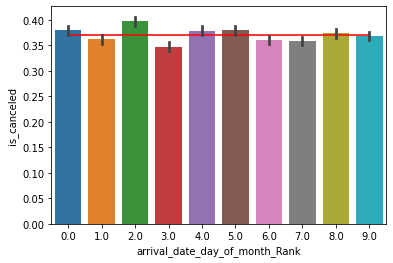

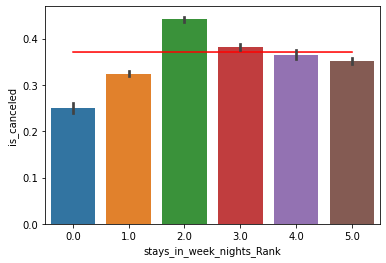

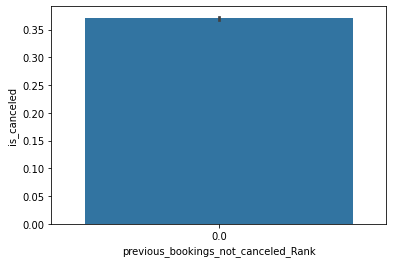

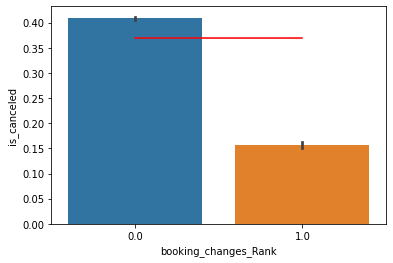

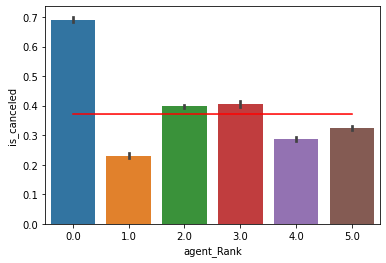

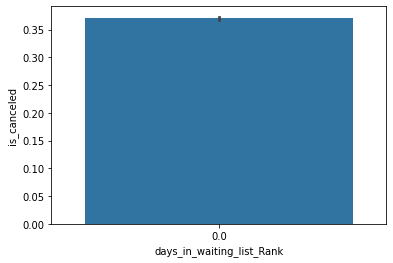

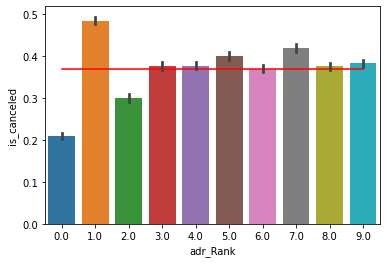

In [36]:
#Check if the features show a slope at all
#If they do, then do you see some deciles below the population average and some higher than population average?
#If that is the case then the slope will be strong
#Conclusion: A strong slope is indicative of the features' ability to discriminate the event from non event
#            making it a good predictor

#percentage_income_goesinto_intallments=Insallment/annual_inc (Derived Variables/Feature Engineering)

X_bin_combined=pd.concat([Y,num_binned],axis=1,join='inner')


for col in (num_binned.columns):
    plt.figure()
    sns.lineplot(x=col,y=X_bin_combined['is_canceled'].mean(),data=X_bin_combined, color = 'red')
    sns.barplot(x=col, y="is_canceled",data=X_bin_combined, estimator=mean )
plt.show()

In [37]:
# Check the descriptive statistics for the following features
# previous_bookings_not_canceled
# days_in_waiting_list
# booking_changes

num_2['day_wait_ind']=np.where(num_2['days_in_waiting_list']>0,1,0)
num_2['previous_bookings_not_canceled_ind']=np.where(num_2['previous_bookings_not_canceled']>0,1,0)
num_2['booking_changes_ind']=np.where(num_2['booking_changes']>0,1,0)

In [38]:
num_varlist=['adr','arrival_date_day_of_month','arrival_date_week_number','days_in_waiting_list','previous_bookings_not_canceled',
            'booking_changes']
num_2=num_2.drop(num_varlist,axis=1)

In [39]:
num_2.dtypes

lead_time                             float64
stays_in_week_nights                  float64
agent                                 float64
day_wait_ind                            int64
previous_bookings_not_canceled_ind      int64
booking_changes_ind                     int64
dtype: object

In [40]:
num_2.shape

(119390, 6)

# Part 2 - Select K Best

In [41]:
selector = SelectKBest(chi2,k=4)
selector.fit_transform(num_2, Y)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
select_features_df_num = num_2.iloc[:,cols]

In [42]:
select_features_df_num.iloc[0]

lead_time                             342.000000
agent                                  86.008598
previous_bookings_not_canceled_ind      0.000000
booking_changes_ind                     1.000000
Name: 0, dtype: float64

# Feature Selection - Categorical Features 

In [43]:
char.dtypes

hotel                           object
arrival_month_year              object
arrival_date_month              object
meal                            object
country                         object
market_segment                  object
distribution_channel            object
reserved_room_type              object
assigned_room_type              object
deposit_type                    object
customer_type                   object
reservation_status              object
reservation_status_date         object
arrival_date_year                int64
stays_in_weekend_nights          int64
adults                           int64
children                       float64
babies                           int64
is_repeated_guest                int64
previous_cancellations           int64
required_car_parking_spaces      int64
total_of_special_requests        int64
dtype: object

# Part 1 - Bi Variate Analysis

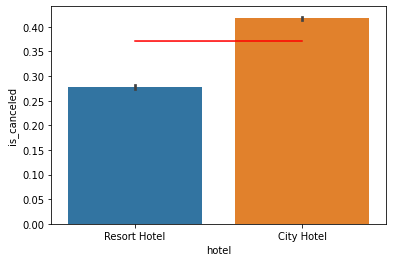

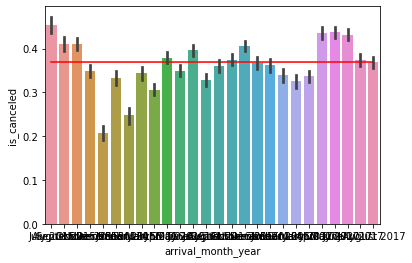

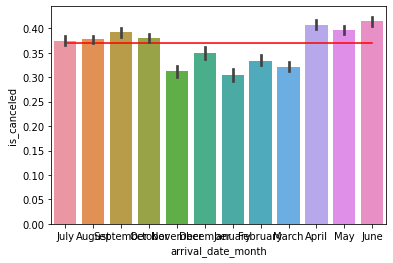

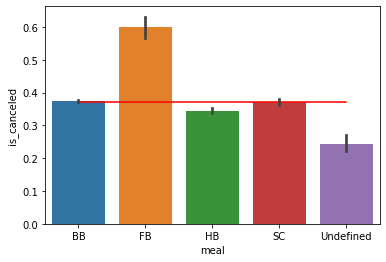

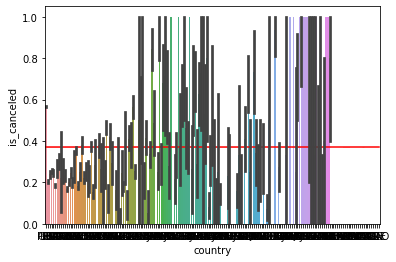

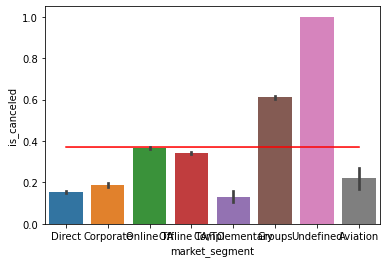

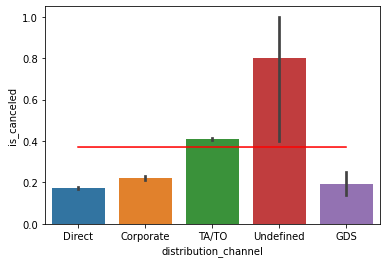

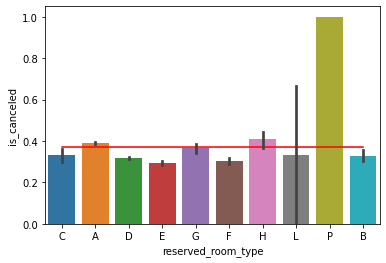

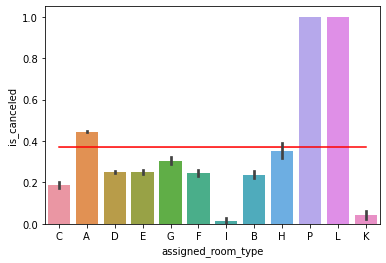

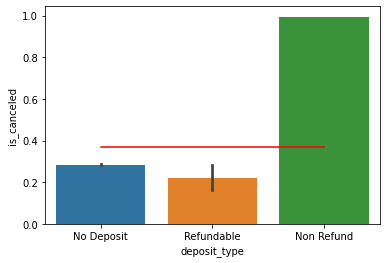

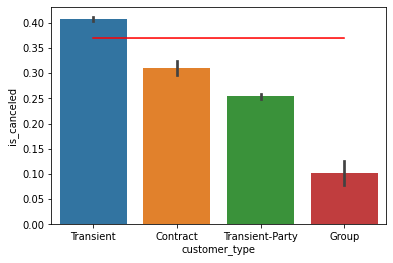

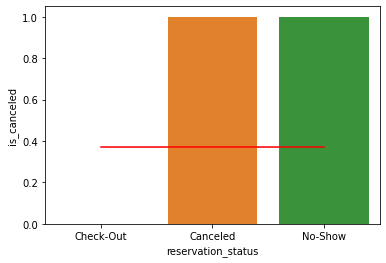

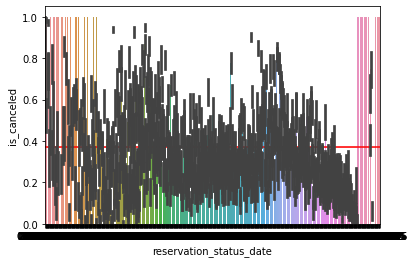

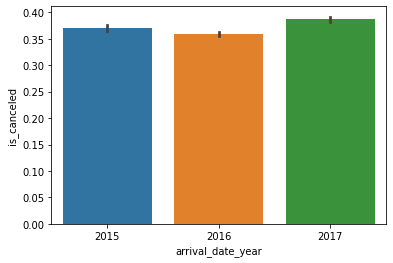

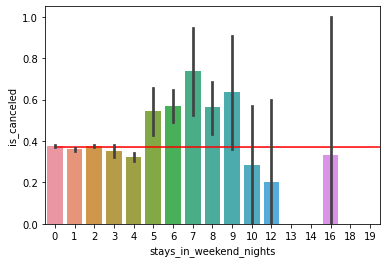

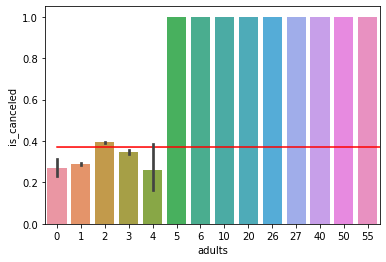

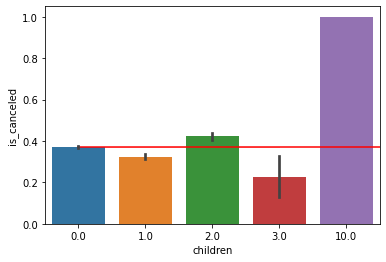

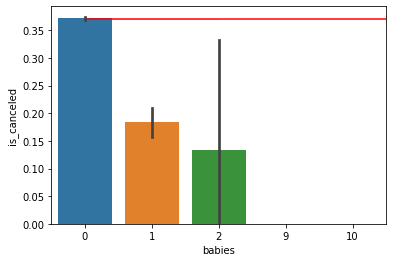

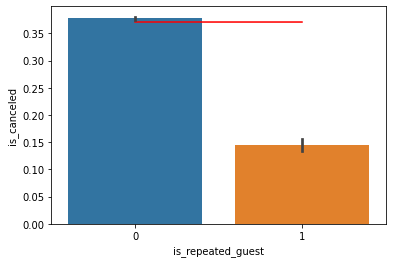

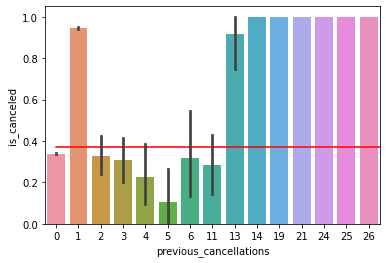

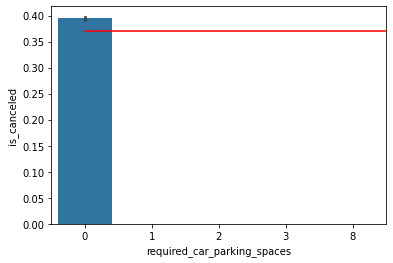

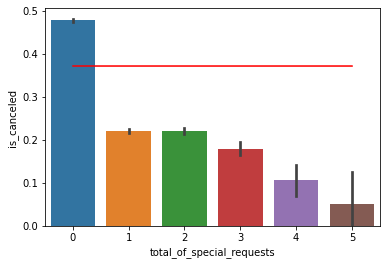

In [44]:
X_char_merged=pd.concat([Y,char],axis=1,join='inner')

for col in (char.columns):
    plt.figure()
    sns.lineplot(x=col,y=X_char_merged['is_canceled'].mean(),data=X_char_merged, color = 'red')
    sns.barplot(x=col, y="is_canceled",data=X_char_merged, estimator=mean )
plt.show()

In [45]:
charlist=['arrival_date_month','country','reserved_room_type','assigned_room_type','reservation_status','reservation_status_date','arrival_date_year']
char_1=char_1.drop(charlist,axis=1)

In [46]:
# Create dummy features with n-1 levels
X_char_dum = pd.get_dummies(char_1, drop_first = True)
X_char_dum.shape

(119390, 107)

# Part 2 - Select K Best

In [47]:
# Select K Best for Categorical Features
selector = SelectKBest(chi2, k=100)
selector.fit_transform(X_char_dum, Y)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
select_features_df_char = X_char_dum.iloc[:,cols]

In [48]:
select_features_df_char.iloc[0]

hotel_Resort Hotel                  1
arrival_month_year_April 2017       0
arrival_month_year_August 2015      0
arrival_month_year_August 2016      0
arrival_month_year_December 2015    0
                                   ..
total_of_special_requests_1         0
total_of_special_requests_2         0
total_of_special_requests_3         0
total_of_special_requests_4         0
total_of_special_requests_5         0
Name: 0, Length: 100, dtype: uint8

# Creating the Master Feature Set for Model Development

In [49]:
X_all=pd.concat([select_features_df_char,select_features_df_num],axis=1,join="inner")

# Train Test Split

In [50]:
X_train, X_test, y_train, y_test=train_test_split(X_all, Y, test_size=0.3, random_state=42)

In [51]:
print("Shape of Training Data",X_train.shape)
print("Shape of Testing Data",X_test.shape)
print("Response Rate in Training Data",y_train.mean())
print("Response Rate in Testing Data",y_test.mean())

Shape of Training Data (83573, 104)
Shape of Testing Data (35817, 104)
Response Rate in Training Data is_canceled    0.369557
dtype: float64
Response Rate in Testing Data is_canceled    0.372421
dtype: float64


In [52]:
# Non Linearity in feature relationships are observed which makes tree methods a good choice
# There are few options to consider among tree methods
# White Box (Completely Explainable Set of Rules) - Decision Tree
# Ensemble Methods - Random Forest (With Bagging)
# Ensemble Methods - GBM/XGBoost (Boosting)

In [53]:
# Building a Decision Tree Model
dtree=DecisionTreeClassifier(criterion='gini',random_state=0)

In [54]:
np.random.seed(44)
param_dist = {'max_depth': [3, 5, 6, 7], 'min_samples_split': [140,280,420,560,700] }
tree_grid = GridSearchCV(dtree, cv = 10, param_grid=param_dist,n_jobs = 3)
tree_grid.fit(X_train,y_train) 
print('Best Parameters using grid search: \n', tree_grid.best_params_)

Best Parameters using grid search: 
 {'max_depth': 7, 'min_samples_split': 140}


In [55]:
dtree=DecisionTreeClassifier(criterion='gini',random_state=0,max_depth=5,min_samples_split=140)
dtree.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=140,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [56]:
# Building a Random Forest Model
rf=RandomForestClassifier(criterion='gini',random_state=0,max_depth=5,min_samples_split=140)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=140,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [57]:
# Building a Gradient Boosting Model
gbm=GradientBoostingClassifier(criterion='mse',random_state=0,max_depth=5,min_samples_split=140)
gbm.fit(X_train,y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=140,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=0, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [58]:
# Model Evaluation
y_pred_tree=dtree.predict(X_test)
y_pred_rf=rf.predict(X_test)
y_pred_gbm=gbm.predict(X_test)

In [59]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_tree))
print("Precision",metrics.precision_score(y_test,y_pred_tree))
print("Recall",metrics.recall_score(y_test,y_pred_tree))
print("f1_score",metrics.f1_score(y_test,y_pred_tree))

Accuracy: 0.7667308819834157
Precision 0.9946407304485907
Recall 0.37566534222955245
f1_score 0.5453556075529195


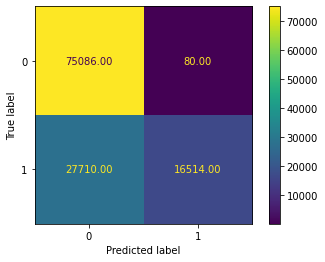

In [60]:
metrics.plot_confusion_matrix(dtree,X_all,Y, values_format = '.2f')

In [61]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_rf))
print("Precision",metrics.precision_score(y_test,y_pred_rf))
print("Recall",metrics.recall_score(y_test,y_pred_rf))
print("f1_score",metrics.f1_score(y_test,y_pred_rf))

Accuracy: 0.7655024150543038
Precision 0.9977831519548569
Recall 0.3711672539170852
f1_score 0.5410633298726846


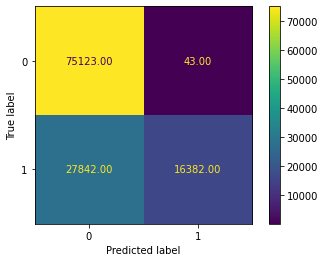

In [62]:
metrics.plot_confusion_matrix(rf,X_all,Y,values_format = '.2f')

In [63]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_gbm))
print("Precision",metrics.precision_score(y_test,y_pred_gbm))
print("Recall",metrics.recall_score(y_test,y_pred_gbm))
print("f1_score",metrics.f1_score(y_test,y_pred_gbm))

Accuracy: 0.8287684619035653
Precision 0.865638319464177
Recall 0.6394782217557538
f1_score 0.7355667658345191


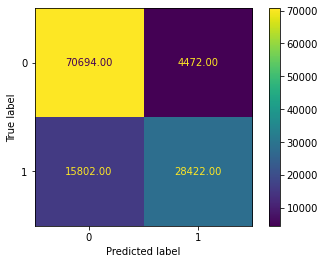

In [64]:
metrics.plot_confusion_matrix(gbm,X_all,Y,values_format = '.2f')

## Lorenz Curve

In [65]:
# Decsion Tree Lorenz Curve

In [66]:
y_pred_prob = gbm.predict_proba(X_all)[:, 1]
df['y_pred_P']=pd.DataFrame(y_pred_prob)
df['P_Rank_dtree']=pd.qcut(df['y_pred_P'].rank(method='first').values,10,duplicates='drop').codes+1
rank_df_actuals=df.groupby('P_Rank_dtree')['is_canceled'].agg(['count','mean'])
rank_df_predicted=df.groupby('P_Rank_dtree')['y_pred_P'].agg(['mean'])
rank_df_actuals=pd.DataFrame(rank_df_actuals)

rank_df_actuals.rename(columns={'mean':'Actutal_event_rate'},inplace=True)
rank_df_predicted=pd.DataFrame(rank_df_predicted)
rank_df_predicted.rename(columns={'mean':'Predicted_event_rate'},inplace=True)
rank_df=pd.concat([rank_df_actuals,rank_df_predicted],axis=1,join="inner")

sorted_rank_df=rank_df.sort_values(by='P_Rank_dtree',ascending=False)
sorted_rank_df['N_events']=rank_df['count']*rank_df['Actutal_event_rate']
sorted_rank_df['cum_events']=sorted_rank_df['N_events'].cumsum()
sorted_rank_df['event_cap']=sorted_rank_df['N_events']/max(sorted_rank_df['N_events'].cumsum())
sorted_rank_df['cum_event_cap']=sorted_rank_df['event_cap'].cumsum()

sorted_rank_df['N_non_events']=sorted_rank_df['count']-sorted_rank_df['N_events']
sorted_rank_df['cum_non_events']=sorted_rank_df['N_non_events'].cumsum()
sorted_rank_df['non_event_cap']=sorted_rank_df['N_non_events']/max(sorted_rank_df['N_non_events'].cumsum())
sorted_rank_df['cum_non_event_cap']=sorted_rank_df['non_event_cap'].cumsum()

sorted_rank_df['KS']=round((sorted_rank_df['cum_event_cap']-sorted_rank_df['cum_non_event_cap']),4)

sorted_rank_df['random_cap']=sorted_rank_df['count']/max(sorted_rank_df['count'].cumsum())
sorted_rank_df['cum_random_cap']=sorted_rank_df['random_cap'].cumsum()
sorted_reindexed=sorted_rank_df.reset_index()
sorted_reindexed['Decile']=sorted_reindexed.index+1
sorted_reindexed['Lift_over_Avg']=sorted_reindexed['Actutal_event_rate']/(max(sorted_reindexed['N_events'].cumsum())/max(sorted_reindexed['count'].cumsum()))
sorted_reindexed

,P_Rank_dtree,count,Actutal_event_rate,Predicted_event_rate,N_events,cum_events,event_cap,cum_event_cap,N_non_events,cum_non_events,non_event_cap,cum_non_event_cap,KS,random_cap,cum_random_cap,Decile,Lift_over_Avg
0,10,11939,1.000000,0.990687,11939.0,11939.0,0.269967,0.269967,0.0,0.0,0.000000,0.000000,0.2700,0.1,0.1,1,2.699665
1,9,11939,0.877042,0.827253,10471.0,22410.0,0.236772,0.506738,1468.0,1468.0,0.019530,0.019530,0.4872,0.1,0.2,2,2.367719
2,8,11939,0.633386,0.571242,7562.0,29972.0,0.170993,0.677732,4377.0,5845.0,0.058231,0.077761,0.6000,0.1,0.3,3,1.709931
3,7,11939,0.400871,0.393246,4786.0,34758.0,0.108222,0.785953,7153.0,12998.0,0.095163,0.172924,0.6130,0.1,0.4,4,1.082218
4,6,11939,0.308317,0.304845,3681.0,38439.0,0.083235,0.869189,8258.0,21256.0,0.109864,0.282787,0.5864,0.1,0.5,5,0.832353
5,5,11939,0.204456,0.231627,2441.0,40880.0,0.055196,0.924385,9498.0,30754.0,0.126360,0.409148,0.5152,0.1,0.6,6,0.551963
6,4,11939,0.129324,0.163034,1544.0,42424.0,0.034913,0.959298,10395.0,41149.0,0.138294,0.547442,0.4119,0.1,0.7,7,0.349132
7,3,11939,0.093224,0.116266,1113.0,43537.0,0.025167,0.984465,10826.0,51975.0,0.144028,0.691470,0.2930,0.1,0.8,8,0.251673
8,2,11939,0.048580,0.076336,580.0,44117.0,0.013115,0.997580,11359.0,63334.0,0.151119,0.842588,0.1550,0.1,0.9,9,0.131151
9,1,11939,0.008962,0.024757,107.0,44224.0,0.002420,1.000000,11832.0,75166.0,0.157412,1.000000,0.0000,0.1,1.0,10,0.024195


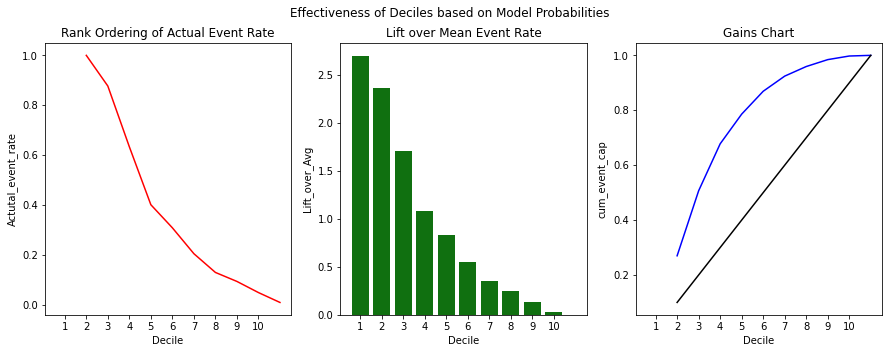

In [67]:
fig, axes = plt.subplots(1, 3, sharex=True, figsize=(15,5))
fig.suptitle('Effectiveness of Deciles based on Model Probabilities')
axes[0].set_title('Rank Ordering of Actual Event Rate')
axes[1].set_title('Lift over Mean Event Rate')
axes[2].set_title('Gains Chart')
sns.lineplot(ax=axes[0],  x="Decile", y="Actutal_event_rate", data=sorted_reindexed,color='red')
sns.barplot(ax=axes[1],  x="Decile", y="Lift_over_Avg", data=sorted_reindexed,color='green')
sns.lineplot(ax=axes[2],  x="Decile", y="cum_event_cap", data=sorted_reindexed,color='blue')
sns.lineplot(ax=axes[2],  x="Decile", y="cum_random_cap", data=sorted_reindexed,color='black')

In [68]:
# Audience
df['Predicted_cancel_Rank']=np.where(df['P_Rank_dtree']<8,"Bottom7","Top3")
df.Predicted_cancel_Rank.value_counts()

Bottom7    83573
Top3       35817
Name: Predicted_cancel_Rank, dtype: int64

In [69]:
df_top3=df.loc[df['Predicted_cancel_Rank']=='Top3',:]

In [70]:
df_top3.shape

(35817, 36)

In [71]:
service_list=['stays_in_weekend_nights','total_of_special_requests','reserved_room_type']

In [72]:
df_top3_services=df_top3[service_list]

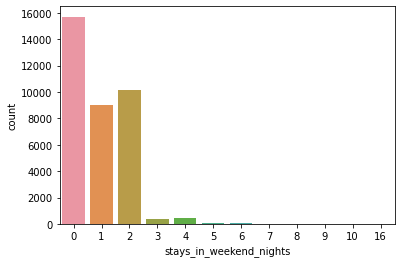

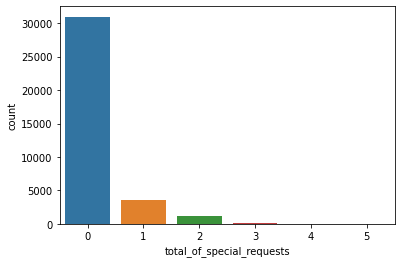

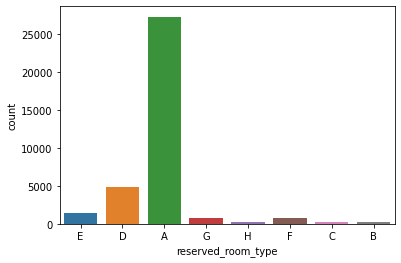

In [73]:
for col in (df_top3_services.columns):
    plt.figure()
    sns.countplot(x=col,data=df_top3_services)
plt.show()

In [74]:
df['lead_time_RANK']=pd.qcut(df['lead_time'].rank(method='first').values,10,duplicates='drop').codes+1

In [75]:
df.groupby('lead_time_RANK')['lead_time'].agg(['min','mean','max'])

,min,mean,max
lead_time_RANK,,,
1,0,0.652735,3
2,3,6.449703,11
3,11,18.337465,26
4,26,35.099757,45
5,45,56.680291,69
6,69,83.823603,99
7,99,117.566044,138
8,138,160.550130,184
9,184,219.433286,265


In [76]:
df.lead_time.mean()

104.01141636652986

In [77]:
df['lead_time_segment']=np.where(df['lead_time_RANK']>=7,"High Lead Time","Low Lead Time")
df.lead_time_segment.value_counts()

Low Lead Time     71634
High Lead Time    47756
Name: lead_time_segment, dtype: int64

In [78]:
df['adr_RANK']=pd.qcut(df['adr'].rank(method='first').values,10,duplicates='drop').codes+1

In [79]:
df.groupby('adr_RANK')['adr'].agg(['min','mean','max'])

,min,mean,max
adr_RANK,,,
1,-6.38,32.638938,50.00
2,50.00,59.250104,64.00
3,64.00,69.332909,75.00
4,75.00,79.526233,85.00
5,85.00,89.482808,94.56
6,94.59,99.285965,105.00
7,105.00,111.376652,118.15
8,118.15,125.793015,135.00
9,135.00,147.667347,164.00


In [80]:
df.adr.mean()

101.83112153446453

In [81]:
df['adr_segment']=np.where(df['adr_RANK']>=7,"High ADR","Low ADR")
df.adr_segment.value_counts()

Low ADR     71634
High ADR    47756
Name: adr_segment, dtype: int64

In [82]:
pd.crosstab(index=df['adr_segment'], columns=df['lead_time_segment'],values=df['adr'],aggfunc='mean')

lead_time_segment,High Lead Time,Low Lead Time
adr_segment,,
High ADR,141.203654,151.099370
Low ADR,74.960245,69.300239


In [83]:
pd.crosstab(index=df['adr_segment'], columns=df['lead_time_segment'],values=df['adr'],aggfunc='count')

lead_time_segment,High Lead Time,Low Lead Time
adr_segment,,
High ADR,18825,28931
Low ADR,28931,42703


In [84]:
pd.crosstab(index=df['adr_segment'], columns=df['lead_time_segment'],values=df['is_canceled'],aggfunc='mean')

lead_time_segment,High Lead Time,Low Lead Time
adr_segment,,
High ADR,0.482231,0.320037
Low ADR,0.528775,0.247969


In [85]:
# Recomendation 
# 1. Customers who have booked a cheaper room with High Lead time is likely to cancel more, provide upgrade before cancellation.
# 2. Hotel can proactively check if they can cater to some special requests
# 3. The reserved room type 'A' has a high cancellation rate: check the problem there and try and fix